# Series de tiempo multivariable

Como vimos en la presentación, los problemas de series de tiempo multivariable se presentan cuando tenemos un dataset con una única columna para representar el tiempo y por cada punto tenemos dos o más valores correspondientes a distintas variables. Un dataset de este tipo debería verse de la siguiente manera:

| tiempo | variable1 | variable2 | ... | variableN |
|----|----|----|----|----|
| 2022-1-1 | 34 | 78 | ... | 112 |
| 2022-1-2 | 12 | 79 | ... | 113 |
| 2022-1-3 | 55 | 80 | ... | 114 |
| 2022-1-4 | 20 | 85 | ... | 115 |
| ... | ... | ... | ... | ... |

## Graficando nuestra serie de tiempo

86400


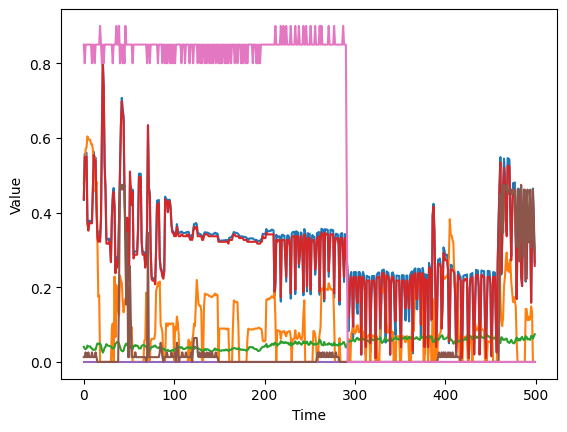

In [1]:
import urllib
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def download_and_extract_data():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/household_power.zip'
    urllib.request.urlretrieve(url, 'household_power.zip')
    with zipfile.ZipFile('household_power.zip', 'r') as zip_ref:
        zip_ref.extractall()

download_and_extract_data()

def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

# Reads the dataset from the CSV.
df = pd.read_csv('household_power_consumption.csv', sep=',',
                  infer_datetime_format=True, index_col='datetime', header=0)

# Number of features in the dataset. We use all features as predictors to
# predict all features at future time steps.
N_FEATURES = len(df.columns) # DO NOT CHANGE THIS

# Normalizes the data
data = df.values
data = normalize_series(data, data.min(axis=0), data.max(axis=0))

# Splits the data into training and validation sets.
SPLIT_TIME = int(len(data) * 0.5) # DO NOT CHANGE THIS
print(int(len(data)))
time = np.arange(int(len(data)))
time_train = time[:SPLIT_TIME]
x_train = data[:SPLIT_TIME]
time_valid = time[SPLIT_TIME:]
x_valid = data[SPLIT_TIME:]

plot_series(time, data, start=0, end=500)

## Instrucciones

Las siguientes instrucciones corresponden a un ejercicio de categoría 5 donde se nos indica qué se espera que resolvamos, aquello que ya nos proveen y el puntaje esperado en términos del MAE (error absoluto medio).

In [ ]:
# ==============================================================================
# There are 5 questions in this exam with increasing difficulty from 1-5.
# Please note that the weight of the grade for the question is relative to its
# difficulty. So your Category 1 question will score significantly less than
# your Category 5 question.
#
# WARNING: Do not use lambda layers in your model, they are not supported
# on the grading infrastructure. You do not need them to solve the question.
#
# WARNING: If you are using the GRU layer, it is advised not to use the
# recurrent_dropout argument (you can alternatively set it to 0),
# since it has not been implemented in the cuDNN kernel and may
# result in much longer training times.
#
# You must use the Submit and Test button to submit your model
# at least once in this category before you finally submit your exam,
# otherwise you will score zero for this category.
# ==============================================================================
#
# TIME SERIES QUESTION
#
# Build and train a neural network to predict time indexed variables of
# the multivariate house hold electric power consumption time series dataset.
# Using a window of past 24 observations of the 7 variables, the model
# should be trained to predict the next 24 observations of the 7 variables.
#
# ==============================================================================
#
# ABOUT THE DATASET
#
# Original Source:
# https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
#
# The original Individual House Hold Electric Power Consumption Dataset
# has Measurements of electric power consumption in one household with
# a one-minute sampling rate over a period of almost 4 years.
#
# Different electrical quantities and some sub-metering values are available.
#
# For the purpose of the examination we have provided a subset containing
# the data for the first 60 days in the dataset. We have also cleaned the
# dataset beforehand to remove missing values. The dataset is provided as a
# CSV file in the project.
#
# The dataset has a total of 7 features ordered by time.
# ==============================================================================
#
# INSTRUCTIONS
#
# Complete the code in following functions:
# 1. solution_model()
#
# Your code will fail to be graded if the following criteria are not met:
#
# 1. Model input shape must be (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7),
#    since the testing infrastructure expects a window of past N_PAST = 24
#    observations of the 7 features to predict the next N_FUTURE = 24
#    observations of the same features.
#
# 2. Model output shape must be (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7)
#
# 3. The last layer of your model must be a Dense layer with 7 neurons since
#    the model is expected to predict observations of 7 features.
#
# 4. Don't change the values of the following constants:
#    SPLIT_TIME, N_FEATURES, BATCH_SIZE, N_PAST, N_FUTURE, SHIFT, in
#    solution_model() (See code for additional note on BATCH_SIZE).
#
# 5. Code for normalizing the data is provided - don't change it.
#    Changing the normalizing code will affect your score.
#
# 6. Code for converting the dataset into windows is provided - don't change it.
#    Changing the windowing code will affect your score.
#
# 7. Code for setting the seed is provided - don't change it.
#
# HINT: If you follow all the rules mentioned above and throughout this
# question while training your neural network, there is a possibility that a
# validation MAE of approximately 0.055 or less on the normalized validation
# dataset may fetch you top marks.

## Código que nos provee el examen

El siguiente código se provee directamente al iniciar el ejercicio, es muy importante no modificarlo pero sí es necesario revisarlo para entender qué es lo que hace y cómo poder utilizarlo a nuestro favor.

In [2]:
import urllib
import zipfile

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# This function downloads and extracts the dataset to the directory that
# contains this file.
# DO NOT CHANGE THIS CODE
# (unless you need to change https to http)
def download_and_extract_data():
    url = 'https://storage.googleapis.com/download.tensorflow.org/data/certificate/household_power.zip'
    urllib.request.urlretrieve(url, 'household_power.zip')
    with zipfile.ZipFile('household_power.zip', 'r') as zip_ref:
        zip_ref.extractall()


# This function normalizes the dataset using min max scaling.
# DO NOT CHANGE THIS CODE
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data


# This function is used to map the time series dataset into windows of
# features and respective targets, to prepare it for training and
# validation. First element of the first window will be the first element of
# the dataset. Consecutive windows are constructed by shifting
# the starting position of the first window forward, one at a time (indicated
# by shift=1). For a window of n_past number of observations of all the time
# indexed variables in the dataset, the target for the window
# is the next n_future number of observations of these variables, after the
# end of the window.

# DO NOT CHANGE THIS CODE
def windowed_dataset(series, batch_size, n_past=24, n_future=24, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

# THIS CODE IS USED IN THE TESTER FOR FORECASTING. IF YOU WANT TO TEST YOUR MODEL
# BEFORE UPLOADING YOU CAN DO IT WITH THIS
def mae(y_true, y_pred):
    return np.mean(abs(y_true.ravel() - y_pred.ravel()))

def model_forecast(model, series, window_size, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
    forecast = model.predict(ds)
    return forecast

## Solution Model: la función que debemos completar

En este punto, las instrucciones del examen indican que solution_model es la función que debemos completar. Esencialmente se nos pide que incluyamos código que permita:


1.   Leer el conjunto de datos
2.   Segmentar el conjunto de datos en el set de entrenamiento y de prueba
3. Construir una red neuronal para encontrar un buen valor de learning rate
4. Construir una red neuronal que entrene con los datos adecuados, que acepte el valor de learning rate que calculamos y genere el modelo que ocuparemos para realizar el forecast.





86400
Inputs shape (batch, time, features): (32, 24, 7)
Labels shape (batch, time, features): (32, 24, 7)
Epoch 1/20
1349/1349 [==============================] - 27s 16ms/step - loss: 0.0156 - mae: 0.1096 - lr: 0.0010
Epoch 2/20
1349/1349 [==============================] - 18s 13ms/step - loss: 0.0113 - mae: 0.0948 - lr: 0.0011
Epoch 3/20
1349/1349 [==============================] - 18s 13ms/step - loss: 0.0106 - mae: 0.0885 - lr: 0.0013
Epoch 4/20
1349/1349 [==============================] - 19s 14ms/step - loss: 0.0102 - mae: 0.0843 - lr: 0.0014
Epoch 5/20
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0100 - mae: 0.0811 - lr: 0.0016
Epoch 6/20
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0098 - mae: 0.0786 - lr: 0.0018
Epoch 7/20
1349/1349 [==============================] - 19s 14ms/step - loss: 0.0096 - mae: 0.0768 - lr: 0.0020
Epoch 8/20
1349/1349 [==============================] - 20s 15ms/step - loss: 0.0095 - mae: 0.0757 - lr: 0.002

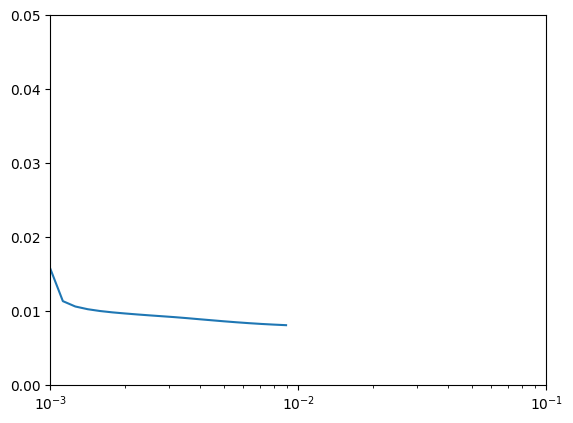

Epoch 1/30
1349/1349 [==============================] - 32s 20ms/step - loss: 0.0128 - mae: 0.0993 - val_loss: 0.0098 - val_mae: 0.0815
Epoch 2/30
1349/1349 [==============================] - 29s 21ms/step - loss: 0.0100 - mae: 0.0807 - val_loss: 0.0094 - val_mae: 0.0792
Epoch 3/30
1349/1349 [==============================] - 29s 22ms/step - loss: 0.0096 - mae: 0.0791 - val_loss: 0.0091 - val_mae: 0.0779
Epoch 4/30
1349/1349 [==============================] - 28s 21ms/step - loss: 0.0094 - mae: 0.0778 - val_loss: 0.0089 - val_mae: 0.0765
Epoch 5/30
1349/1349 [==============================] - 30s 22ms/step - loss: 0.0091 - mae: 0.0764 - val_loss: 0.0087 - val_mae: 0.0750
Epoch 6/30
1349/1349 [==============================] - 33s 24ms/step - loss: 0.0089 - mae: 0.0751 - val_loss: 0.0085 - val_mae: 0.0734
Epoch 7/30
1349/1349 [==============================] - 35s 26ms/step - loss: 0.0087 - mae: 0.0738 - val_loss: 0.0083 - val_mae: 0.0719
Epoch 8/30
1349/1349 [==========================

In [3]:
# This function loads the data from CSV file, normalizes the data and
# splits the dataset into train and validation data. It also uses
# windowed_dataset() to split the data into windows of observations and
# targets. Finally it defines, compiles and trains a neural network. This
# function returns the final trained model.

# COMPLETE THE CODE IN THIS FUNCTION
def solution_model():
    # Downloads and extracts the dataset to the directory that
    # contains this file.
    download_and_extract_data()
    # Reads the dataset from the CSV.
    df = pd.read_csv('household_power_consumption.csv', sep=',',
                     infer_datetime_format=True, index_col='datetime', header=0)

    # Number of features in the dataset. We use all features as predictors to
    # predict all features at future time steps.
    N_FEATURES = len(df.columns) # DO NOT CHANGE THIS

    # Normalizes the data
    data = df.values
    data = normalize_series(data, data.min(axis=0), data.max(axis=0))

    # Splits the data into training and validation sets.
    SPLIT_TIME = int(len(data) * 0.5) # DO NOT CHANGE THIS
    print(int(len(data)))
    time = np.arange(int(len(data)))
    time_train = time[:SPLIT_TIME]
    x_train = data[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    x_valid = data[SPLIT_TIME:]

    # DO NOT CHANGE THIS CODE
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    # DO NOT CHANGE BATCH_SIZE IF YOU ARE USING STATEFUL LSTM/RNN/GRU.
    # THE TEST WILL FAIL TO GRADE YOUR SCORE IN SUCH CASES.
    # In other cases, it is advised not to change the batch size since it
    # might affect your final scores. While setting it to a lower size
    # might not do any harm, higher sizes might affect your scores.
    BATCH_SIZE = 32  # ADVISED NOT TO CHANGE THIS

    # DO NOT CHANGE N_PAST, N_FUTURE, SHIFT. The tests will fail to run
    # on the server.
    # Number of past time steps based on which future observations should be
    # predicted
    N_PAST = 24  # DO NOT CHANGE THIS

    # Number of future time steps which are to be predicted.
    N_FUTURE = 24  # DO NOT CHANGE THIS

    # By how many positions the window slides to create a new window
    # of observations.
    SHIFT = 1  # DO NOT CHANGE THIS

    # Code to create windowed train and validation datasets.
    train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    
    # VALIDATE INPUT AND OUTPUT SHAPE
    for example_inputs, example_labels in train_set.take(1):
        print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
        print(f'Labels shape (batch, time, features): {example_labels.shape}')

    # Find an appropiate learning rate
    model = tf.keras.models.Sequential([      
      tf.keras.layers.Dense(BATCH_SIZE, input_shape=[N_PAST, N_FEATURES]), # (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7)                          
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None, N_FEATURES])),# input_shape=train_set_shape),
      tf.keras.layers.Dense(30, activation="relu"),
      tf.keras.layers.Dense(10, activation="relu"),
      tf.keras.layers.Dense(N_FEATURES)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-3 * 10 ** (epoch / 20)) # 0.01
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])

    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([1e-3, 1e-1, 0, 0.05])
    plt.show()
    

    # Early Stopping Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10) # Detener el entrenamiento si el modelo no mejora
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint( # De todas las iteraciones, guardamos el mejor modelo
        "c5q4.h5", save_best_only=True
    )

    np.random.seed(42)

    # Code to define your model.
    model = tf.keras.models.Sequential([

        # ADD YOUR LAYERS HERE.

        # If you don't follow the instructions in the following comments,
        # tests will fail to grade your code:
        # The input layer of your model must have an input shape of:
        # (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7)
        # The model must have an output shape of:
        # (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7).
        # Make sure that there are N_FEATURES = 7 neurons in the final dense
        # layer since the model predicts 7 features.

        # HINT: Bidirectional LSTMs may help boost your score. This is only a
        # suggestion.

        # WARNING: If you are using the GRU layer, it is advised not to use the
        # recurrent_dropout argument (you can alternatively set it to 0),
        # since it has not been implemented in the cuDNN kernel and may
        # result in much longer training times.

        #### BASELINE ####
        #tf.keras.layers.Dense(10, activation='relu'),
        #tf.keras.layers.Dense(30, activation="relu"),
        #tf.keras.layers.Dense(10, activation="relu"),

        #### CNN ####
        #tf.keras.layers.Conv1D(filters=32,
        #                       kernel_size=(N_PAST,),
        #                       activation='relu'),
        #tf.keras.layers.Dense(units=32, activation='relu'),

        #### LSTM ####
        tf.keras.layers.Dense(BATCH_SIZE, input_shape=[N_PAST, N_FEATURES]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=[None, N_FEATURES])),# input_shape=train_set_shape),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(N_FEATURES)
    ])

    # Code to train and compile the model
    # Cambiar el learning, bajarlo a 1e-6
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, # learning_rate=1e-6,
                                        momentum=0.9)
    model.compile(
        loss=tf.keras.losses.Huber(), # Sugerencias: Poner MAE como loss function, Huber para muchos outliers
        optimizer=optimizer,
        metrics=["mae"]
    )

    model.fit(
        train_set, epochs=30,
        validation_data=valid_set,
        callbacks=[early_stopping, model_checkpoint]
    )

    # PASS THE NORMALIZED data IN THE FOLLOWING CODE
    rnn_forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
    rnn_forecast = rnn_forecast[SPLIT_TIME - N_PAST:-1, 0, :] # predicciones que corresponden al set de validacion  

    x_valid = x_valid[:rnn_forecast.shape[0]]
    result = mae(x_valid, rnn_forecast)
    # plot_series(np.arange(0, SPLIT_TIME), rnn_forecast)
    print(f'MAE alcanzado en forecast: {result}')

    return model


# Note that you'll need to save your model as a .h5 like this.
# When you press the Submit and Test button, your saved .h5 model will
# be sent to the testing infrastructure for scoring
# and the score will be returned to you.

if __name__ == '__main__':
    model = solution_model()
    # model.save("c5q4.h5") # Comentándola evitamos sobreescribir al mejor modelo de ModelCheckpoint


86400
Inputs shape (batch, time, features): (32, 24, 7)
Labels shape (batch, time, features): (32, 24, 7)
Epoch 1/20
1349/1349 [==============================] - 11s 5ms/step - loss: 0.0196 - mae: 0.1180 - lr: 0.0010
Epoch 2/20
1349/1349 [==============================] - 8s 6ms/step - loss: 0.0153 - mae: 0.1124 - lr: 0.0011
Epoch 3/20
1349/1349 [==============================] - 8s 6ms/step - loss: 0.0121 - mae: 0.1030 - lr: 0.0013
Epoch 4/20
1349/1349 [==============================] - 7s 5ms/step - loss: 0.0100 - mae: 0.0892 - lr: 0.0014
Epoch 5/20
1349/1349 [==============================] - 7s 5ms/step - loss: 0.0093 - mae: 0.0810 - lr: 0.0016
Epoch 6/20
1349/1349 [==============================] - 7s 5ms/step - loss: 0.0090 - mae: 0.0770 - lr: 0.0018
Epoch 7/20
1349/1349 [==============================] - 8s 6ms/step - loss: 0.0087 - mae: 0.0744 - lr: 0.0020
Epoch 8/20
1349/1349 [==============================] - 7s 5ms/step - loss: 0.0085 - mae: 0.0727 - lr: 0.0022
Epoch 9/20
13

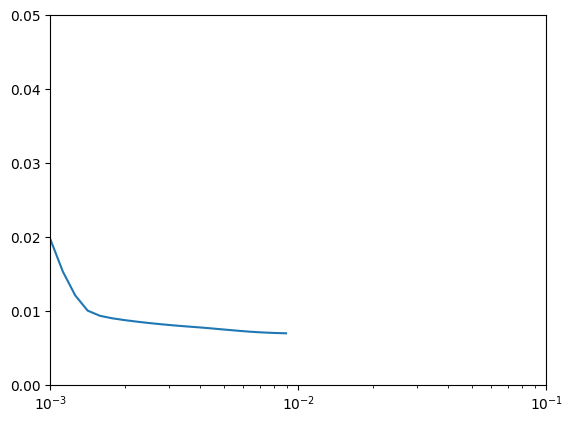

Epoch 1/30
1349/1349 [==============================] - 18s 10ms/step - loss: 0.0153 - mae: 0.1107 - val_loss: 0.0094 - val_mae: 0.0838
Epoch 2/30
1349/1349 [==============================] - 15s 11ms/step - loss: 0.0091 - mae: 0.0766 - val_loss: 0.0082 - val_mae: 0.0715
Epoch 3/30
1349/1349 [==============================] - 14s 10ms/step - loss: 0.0084 - mae: 0.0724 - val_loss: 0.0079 - val_mae: 0.0688
Epoch 4/30
1349/1349 [==============================] - 14s 10ms/step - loss: 0.0082 - mae: 0.0709 - val_loss: 0.0077 - val_mae: 0.0675
Epoch 5/30
1349/1349 [==============================] - 14s 11ms/step - loss: 0.0080 - mae: 0.0698 - val_loss: 0.0076 - val_mae: 0.0667
Epoch 6/30
1349/1349 [==============================] - 15s 11ms/step - loss: 0.0078 - mae: 0.0682 - val_loss: 0.0075 - val_mae: 0.0648
Epoch 7/30
1349/1349 [==============================] - 13s 9ms/step - loss: 0.0075 - mae: 0.0659 - val_loss: 0.0073 - val_mae: 0.0631
Epoch 8/30
1349/1349 [===========================

In [6]:
# This function loads the data from CSV file, normalizes the data and
# splits the dataset into train and validation data. It also uses
# windowed_dataset() to split the data into windows of observations and
# targets. Finally it defines, compiles and trains a neural network. This
# function returns the final trained model.

# COMPLETE THE CODE IN THIS FUNCTION
def solution_model():
    # Downloads and extracts the dataset to the directory that
    # contains this file.
    download_and_extract_data()
    # Reads the dataset from the CSV.
    df = pd.read_csv('household_power_consumption.csv', sep=',',
                     infer_datetime_format=True, index_col='datetime', header=0)

    # Number of features in the dataset. We use all features as predictors to
    # predict all features at future time steps.
    N_FEATURES = len(df.columns) # DO NOT CHANGE THIS

    # Normalizes the data
    data = df.values
    data = normalize_series(data, data.min(axis=0), data.max(axis=0))

    # Splits the data into training and validation sets.
    SPLIT_TIME = int(len(data) * 0.5) # DO NOT CHANGE THIS
    print(int(len(data)))
    time = np.arange(int(len(data)))
    time_train = time[:SPLIT_TIME]
    x_train = data[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    x_valid = data[SPLIT_TIME:]

    # DO NOT CHANGE THIS CODE
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)

    # DO NOT CHANGE BATCH_SIZE IF YOU ARE USING STATEFUL LSTM/RNN/GRU.
    # THE TEST WILL FAIL TO GRADE YOUR SCORE IN SUCH CASES.
    # In other cases, it is advised not to change the batch size since it
    # might affect your final scores. While setting it to a lower size
    # might not do any harm, higher sizes might affect your scores.
    BATCH_SIZE = 32  # ADVISED NOT TO CHANGE THIS

    # DO NOT CHANGE N_PAST, N_FUTURE, SHIFT. The tests will fail to run
    # on the server.
    # Number of past time steps based on which future observations should be
    # predicted
    N_PAST = 24  # DO NOT CHANGE THIS

    # Number of future time steps which are to be predicted.
    N_FUTURE = 24  # DO NOT CHANGE THIS

    # By how many positions the window slides to create a new window
    # of observations.
    SHIFT = 1  # DO NOT CHANGE THIS

    # Code to create windowed train and validation datasets.
    train_set = windowed_dataset(series=x_train, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    valid_set = windowed_dataset(series=x_valid, batch_size=BATCH_SIZE,
                                 n_past=N_PAST, n_future=N_FUTURE,
                                 shift=SHIFT)
    
    # VALIDATE INPUT AND OUTPUT SHAPE
    for example_inputs, example_labels in train_set.take(1):
        print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
        print(f'Labels shape (batch, time, features): {example_labels.shape}')

    # Find an appropiate learning rate
    model = tf.keras.models.Sequential([      
        tf.keras.layers.Conv1D(filters=32,
                               input_shape=[N_PAST, N_FEATURES],
                              kernel_size=(N_PAST,),
                               activation='relu'),         
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, N_FEATURES])),        
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(N_FEATURES)
    ])

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-3 * 10 ** (epoch / 20)) # 0.01
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])

    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([1e-3, 1e-1, 0, 0.05])
    plt.show()
    

    # Early Stopping Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=10) # Detener el entrenamiento si el modelo no mejora
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint( # De todas las iteraciones, guardamos el mejor modelo
        "c5q4.h5", save_best_only=True
    )

    np.random.seed(42)

    # Code to define your model.
    model = tf.keras.models.Sequential([

        # ADD YOUR LAYERS HERE.

        # If you don't follow the instructions in the following comments,
        # tests will fail to grade your code:
        # The input layer of your model must have an input shape of:
        # (BATCH_SIZE, N_PAST = 24, N_FEATURES = 7)
        # The model must have an output shape of:
        # (BATCH_SIZE, N_FUTURE = 24, N_FEATURES = 7).
        # Make sure that there are N_FEATURES = 7 neurons in the final dense
        # layer since the model predicts 7 features.

        # HINT: Bidirectional LSTMs may help boost your score. This is only a
        # suggestion.

        # WARNING: If you are using the GRU layer, it is advised not to use the
        # recurrent_dropout argument (you can alternatively set it to 0),
        # since it has not been implemented in the cuDNN kernel and may
        # result in much longer training times.

        #### BASELINE ####
        #tf.keras.layers.Dense(10, activation='relu'),
        #tf.keras.layers.Dense(30, activation="relu"),
        #tf.keras.layers.Dense(10, activation="relu"),

        #### CNN ####
        
        tf.keras.layers.Conv1D(filters=32,
                               input_shape=[N_PAST, N_FEATURES],
                              kernel_size=(N_PAST,),
                               activation='relu'),         
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True, input_shape=[None, N_FEATURES])),        
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(N_FEATURES)


    ])

    # Code to train and compile the model
    # Cambiar el learning, bajarlo a 1e-6
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, # learning_rate=1e-6,
                                        momentum=0.9)
    model.compile(
        loss=tf.keras.losses.Huber(), # Sugerencias: Poner MAE como loss function, Huber para muchos outliers
        optimizer=optimizer,
        metrics=["mae"]
    )

    model.fit(
        train_set, epochs=30,
        validation_data=valid_set,
        callbacks=[early_stopping, model_checkpoint]
    )

    # PASS THE NORMALIZED data IN THE FOLLOWING CODE
    rnn_forecast = model_forecast(model, data, N_PAST, BATCH_SIZE)
    rnn_forecast = rnn_forecast[SPLIT_TIME - N_PAST:-1, 0, :] # predicciones que corresponden al set de validacion  

    x_valid = x_valid[:rnn_forecast.shape[0]]
    result = mae(x_valid, rnn_forecast)
    # plot_series(np.arange(0, SPLIT_TIME), rnn_forecast)
    print(f'MAE alcanzado en forecast: {result}')

    return model


# Note that you'll need to save your model as a .h5 like this.
# When you press the Submit and Test button, your saved .h5 model will
# be sent to the testing infrastructure for scoring
# and the score will be returned to you.

if __name__ == '__main__':
    model = solution_model()
    # model.save("c5q4.h5") # Comentándola evitamos sobreescribir al mejor modelo de ModelCheckpoint


In [ ]:
# Challenge completed